In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from NFM import NFM

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""数据准备"""
file_path = './preprocessed_data/'
def prepared_data(file_path):
    # 读入训练集， 验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    sparse_feas = [col for col in train.columns if col[0] == 'C']
    dense_feas = [col for col in train.columns if col[0] == 'I']
    
    trn_x, trn_y = [train[dense_feas].values, train[sparse_feas].values], train['Label'].values
    val_x, val_y = [val[dense_feas].values, val[sparse_feas].values], val['Label'].values
    test_x = [test[dense_feas].values, test[sparse_feas].values]
    
    fea_info = np.load(file_path + 'fea_info.npy', allow_pickle=True)
    
    return fea_info, (trn_x, trn_y), (val_x, val_y), test_x

In [3]:
"""导入数据"""
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [5]:
"""设置超参数"""
embed_dim = 8
dnn_dropout = 0.5
hidden_units = [256, 128, 64]

learning_rate = 0.001
batch_size = 64
epochs = 50

In [6]:
"""模型建立"""
model = NFM(fea_cols, hidden_units, dnn_dropout=dnn_dropout)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None,)              0           input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate),
                      metrics=[AUC()])

In [8]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)
]

history = model.fit(
                    trn_x,
                    trn_y,
                    epochs=epochs,
                    callbacks=callbacks,  # checkpoint
                    batch_size=batch_size,
                    validation_split=0.1
                    )

Epoch 1/50
18/18 [==============================] - 3s 49ms/step - loss: 0.6044 - auc: 0.4751 - val_loss: 0.5115 - val_auc: 0.6672
Epoch 2/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4933 - auc: 0.7027 - val_loss: 0.5011 - val_auc: 0.6904
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4324 - auc: 0.8069 - val_loss: 0.5169 - val_auc: 0.6830
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.2863 - auc: 0.9517 - val_loss: 0.6582 - val_auc: 0.6425
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 0.1115 - auc: 0.9925 - val_loss: 0.8803 - val_auc: 0.6580

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0462 - auc: 0.9990 - val_loss: 0.8829 - val_auc: 0.6564
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0425 - auc: 0.9996 - val_loss: 0.8860 - val_auc: 0.6581


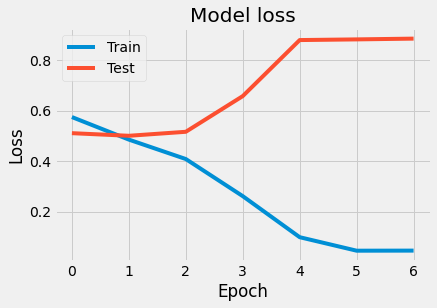

In [9]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

这个目前需要加数据， 训练效果不是太好

In [10]:
"""模型评估"""
print('test AUC: %f' % model.evaluate(val_x, val_y, batch_size=batch_size)[1])

5/5 [==============================] - 0s 1ms/step - loss: 0.4253 - auc: 0.6903
test AUC: 0.690305
